# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender

The dataset is highly unbalanced, resources for an unbiased estimate have been implemented.

In [193]:
import optuna
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop, AdamW
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from focal_loss import SparseCategoricalFocalLoss
import shap
from keras.regularizers import l1, l2, L1L2

In [194]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


## Define Functions

In [195]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [196]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [197]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [198]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [199]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, -10), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

# RANDOM SEED 1

## Prepare Data

In [200]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [201]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [202]:
tf.keras.backend.clear_session()

## Run Setup

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # # check group splits
    # check_initial_group_split(groups_train_val, groups_test)

    # # Specify the cat_ids that must be in the training/validation set
    # specific_cat_ids = ['000A', '046A']
    
    # # Perform the swapping operation
    # train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # # Re-assign the sets based on the updated indices
    # X_train_val, X_test = X[train_val_idx], X[test_idx]
    # y_train_val, y_test = y[train_val_idx], y[test_idx]
    # new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # # Find differences for training and test sets
    # moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    # moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # # Display the results
    # logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    # logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    # logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    # logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    # X_train_val = X[train_val_idx]
    # y_train_val = y[train_val_idx]
    # groups_train_val = groups[train_val_idx]
    
    # X_test = X[test_idx]
    # y_test = y[test_idx]
    # groups_test = groups[test_idx]

    # # logging identifier splits again after potential swaps
    # unique_train_val_groups = np.unique(groups_train_val)
    # unique_test_groups = np.unique(groups_test)
    
    # logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    # logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # # Verify the lengths are consistent
    # logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    # logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    # logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # # Check group splits once more
    # check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=300, batch_size=32,
                                  verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
047A    28
057A    27
055A    20
097A    16
059A    14
111A    13
116A    12
051A    12
040A    10
014B    10
045A     9
094A     8
117A     7
050A     7
109A     6
108A     6
044A     5
104A     4
058A     3
056A     3
054A     2
093A     2
011A     2
061A     2
043A     1
049A     1
041A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
046A    63
106A    14
042A    14
016A    10
051B     9
113A     3
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    147
F     64
M     25
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    77
M    33
F     3
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 040A, 047A, 109A, 050A, 043...
senior    [093A, 097A, 057A, 104A, 055A, 059A, 116A, 054...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Se

Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 113, Predictions: 113, Actuals: 113, Gender: 113
Final Test Results - Loss: 0.9475265741348267, Accuracy: 0.8761062026023865, Precision: 0.854639844256976, Recall: 0.8943001443001443, F1 Score: 0.8660230352303524
Confusion Matrix:
 [[65 12]
 [ 2 34]]
outer_fold 2
Train Set Group Distribution:
046A    63
055A    20
106A    14
042A    14
116A    12
016A    10
040A    10
051B     9
045A     9
050A     7
117A     7
108A     6
044A     5
058A     3
056A     3
113A     3
093A     2
061A     2
011A     2
090A     1
110A     1
115A     1
043A     1
048A     1
041A     1
049A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
047A    28
057A    27
097A    16
059A    14
111A    13
051A    12
014B    10
094A     8
109A     6
104A     4
054A     2
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    122
F     51
M     36
Name: gender, dtype: int64
Testin


outer_fold 3
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
059A    14
106A    14
042A    14
111A    13
116A    12
051A    12
016A    10
014B    10
040A    10
051B     9
094A     8
117A     7
109A     6
104A     4
113A     3
056A     3
054A     2
093A     2
049A     1
048A     1
090A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
045A    9
050A    7
108A    6
044A    5
058A    3
011A    2
061A    2
043A    1
041A    1
115A    1
110A    1
024A    1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    196
F     59
M     55
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    28
F     8
M     3
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [014B, 111A, 040A, 046A, 047A, 042A, 109A, 049...
senior    [093A, 097A, 057A, 106A, 104A, 055A, 059A, 113...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_grou

outer_fold 4
Train Set Group Distribution:
046A    63
047A    28
057A    27
097A    16
042A    14
106A    14
059A    14
111A    13
051A    12
016A    10
014B    10
051B     9
045A     9
094A     8
050A     7
108A     6
109A     6
044A     5
104A     4
058A     3
113A     3
061A     2
011A     2
054A     2
041A     1
043A     1
115A     1
110A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
055A    20
116A    12
040A    10
117A     7
056A     3
093A     2
049A     1
048A     1
090A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    207
M     58
F     27
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    40
X    17
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 046A, 047A, 042A, 109A, 050...
senior    [097A, 057A, 106A, 104A, 059A, 113A, 051B, 054...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_g

## Majority Voting on Total Entries per cat_id 

In [204]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 349, Predictions: 349, Actuals: 349, Gender: 349


In [205]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [206]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.89 (34/38)


In [207]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [208]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
28,104A,"[1, 1, 1, 1]",1,1.0,True
1,014B,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0.0,True
20,057A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",1,1.0,True
22,059A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
24,090A,[1],1,1.0,True
26,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,097A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
29,106A,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]",1,1.0,True
17,054A,"[1, 1]",1,1.0,True


In [209]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    16
1.0    18
Name: Majority_Correct, dtype: int64


In [210]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count    accuracy
0               0.0           16             16  100.000000
1               1.0           22             18   81.818182


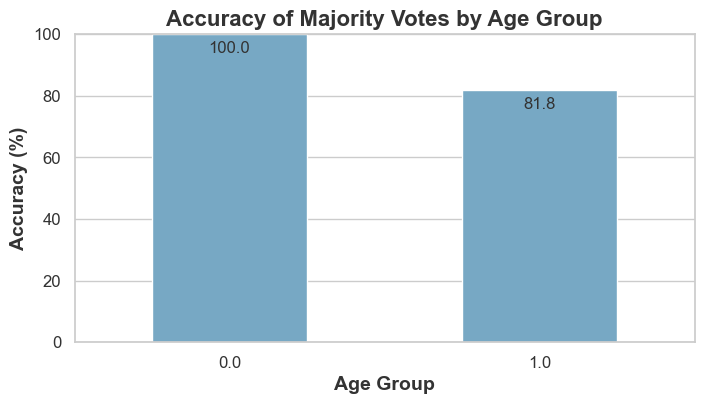

In [211]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [212]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          171            157  91.812865
1               1.0          178            163  91.573034


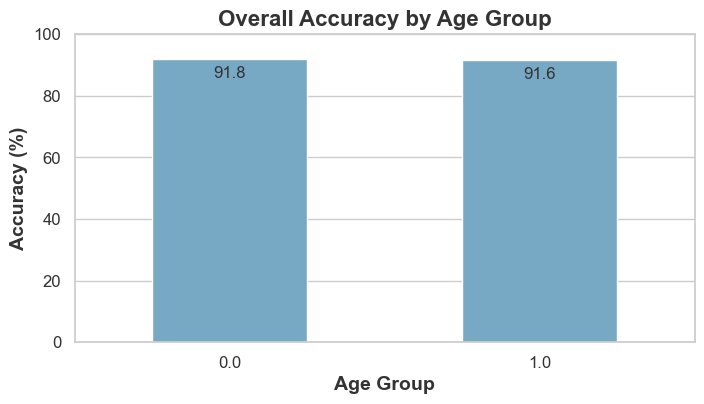

In [213]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [214]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       55     94.83
2          X    224      204     91.07


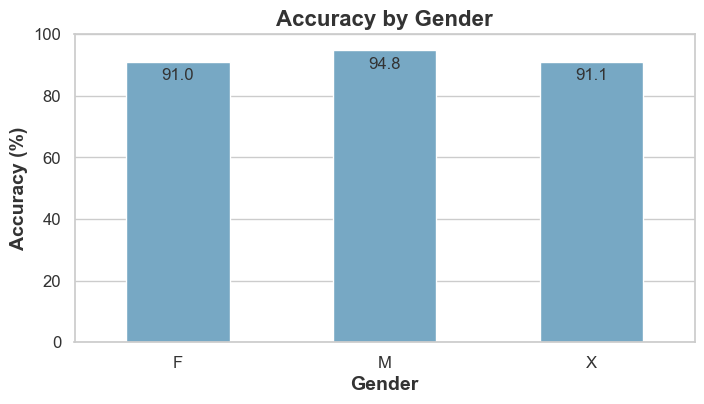

In [215]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# RANDOM SEED 2

In [216]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1])) 
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [217]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [218]:
tf.keras.backend.clear_session()

## Run Setup

In [219]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # # check group splits
    # check_initial_group_split(groups_train_val, groups_test)

    # # Specify the cat_ids that must be in the training/validation set
    # specific_cat_ids = ['000A', '046A']
    
    # # Perform the swapping operation
    # train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # # Re-assign the sets based on the updated indices
    # X_train_val, X_test = X[train_val_idx], X[test_idx]
    # y_train_val, y_test = y[train_val_idx], y[test_idx]
    # new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # # Find differences for training and test sets
    # moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    # moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # # Display the results
    # logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    # logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    # logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    # logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    # X_train_val = X[train_val_idx]
    # y_train_val = y[train_val_idx]
    # groups_train_val = groups[train_val_idx]
    
    # X_test = X[test_idx]
    # y_test = y[test_idx]
    # groups_test = groups[test_idx]

    # # logging identifier splits again after potential swaps
    # unique_train_val_groups = np.unique(groups_train_val)
    # unique_test_groups = np.unique(groups_test)
    
    # logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    # logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # # Verify the lengths are consistent
    # logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    # logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    # logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # # Check group splits once more
    # check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=300, batch_size=32,
                                  verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
057A    27
097A    16
106A    14
042A    14
059A    14
111A    13
116A    12
014B    10
040A    10
016A    10
045A     9
051B     9
094A     8
050A     7
117A     7
109A     6
108A     6
104A     4
056A     3
058A     3
113A     3
054A     2
061A     2
049A     1
041A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
055A    20
051A    12
044A     5
093A     2
011A     2
043A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    216
M     58
F     33
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    34
X     8
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [014B, 111A, 040A, 046A, 047A, 042A, 109A, 050...
senior    [097A, 057A, 106A, 104A, 059A, 113A, 116A, 051...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_g

Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 42, Predictions: 42, Actuals: 42, Gender: 42
Final Test Results - Loss: 0.1516280174255371, Accuracy: 0.9285714030265808, Precision: 0.8333333333333333, Recall: 0.9583333333333333, F1 Score: 0.8782608695652174
Confusion Matrix:
 [[ 6  0]
 [ 3 33]]
outer_fold 2
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
106A    14
042A    14
051A    12
116A    12
040A    10
016A    10
014B    10
045A     9
050A     7
109A     6
108A     6
044A     5
104A     4
056A     3
058A     3
113A     3
093A     2
011A     2
043A     1
049A     1
041A     1
110A     1
090A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
097A    16
059A    14
111A    13
051B     9
094A     8
117A     7
054A     2
061A     2
048A     1
115A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    191
F     60
M     24
Name: gender, dtype: int64
Testing S

Epoch 1/300
6/6 [==============================] - 0s 2ms/step - loss: 0.9146 - accuracy: 0.6025
Epoch 2/300
6/6 [==============================] - 0s 2ms/step - loss: 0.5530 - accuracy: 0.7516
Epoch 3/300
6/6 [==============================] - 0s 1ms/step - loss: 0.4436 - accuracy: 0.7764
Epoch 4/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.7764
Epoch 5/300
6/6 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.7826
Epoch 6/300
6/6 [==============================] - 0s 1ms/step - loss: 0.3745 - accuracy: 0.8385
Epoch 7/300
6/6 [==============================] - 0s 1ms/step - loss: 0.3160 - accuracy: 0.8571
Epoch 8/300
6/6 [==============================] - 0s 1ms/step - loss: 0.3282 - accuracy: 0.8571
Epoch 9/300
6/6 [==============================] - 0s 1ms/step - loss: 0.3246 - accuracy: 0.8261
Epoch 10/300
6/6 [==============================] - 0s 1ms/step - loss: 0.3599 - accuracy: 0.8447
Epoch 11/300
6/6 [===========

Testing Set Group Distribution:
042A    14
116A    12
108A     6
104A     4
113A     3
058A     3
049A     1
041A     1
090A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    205
M     58
F     41
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    26
X    19
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 040A, 046A, 047A, 109A, 050...
senior    [093A, 097A, 057A, 106A, 055A, 059A, 051B, 054...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
kitten                      [042A, 049A, 041A]
senior    [104A, 113A, 116A, 058A, 108A, 090A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 13, 'senior': 16}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 3, 'senior': 6}
Unique Training/Validation Group IDs:
['011A' '014B' '016A' '024A' '040A' '043A' '044A

## Majority Voting on Total Entries per cat_id 

In [220]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 349, Predictions: 349, Actuals: 349, Gender: 349


In [221]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [222]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.84 (32/38)


In [223]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [224]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
28,104A,"[1, 1, 1, 1]",1,1.0,True
1,014B,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0.0,True
20,057A,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, ...",1,1.0,True
22,059A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
24,090A,[1],1,1.0,True
26,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,097A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]",1,1.0,True
29,106A,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]",1,1.0,True
17,054A,"[1, 1]",1,1.0,True


In [225]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    14
1.0    18
Name: Majority_Correct, dtype: int64


In [226]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count   accuracy
0               0.0           16             14  87.500000
1               1.0           22             18  81.818182


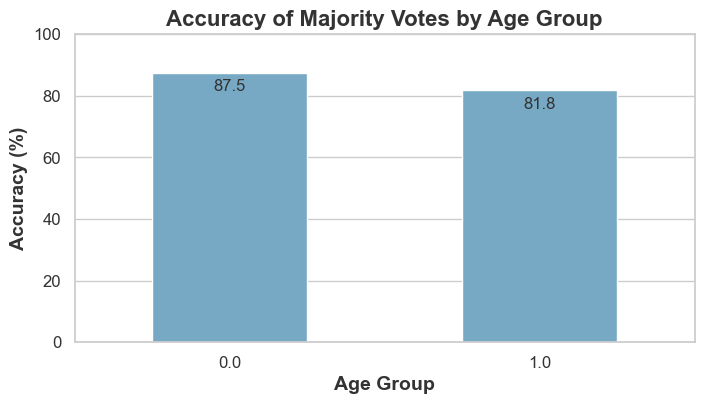

In [227]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [228]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          171            138  80.701754
1               1.0          178            158  88.764045


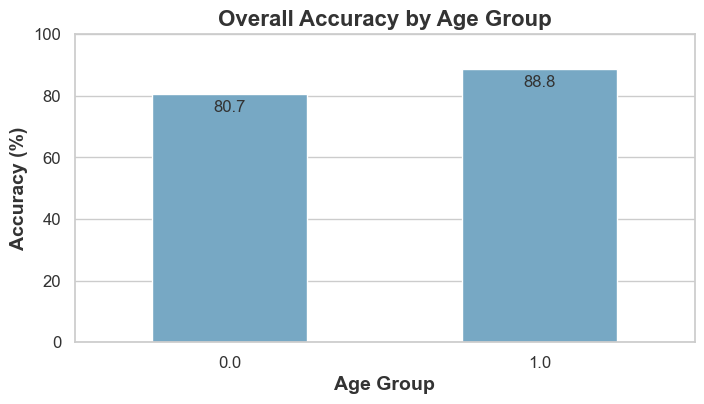

In [229]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [230]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       62     92.54
1          M     58       55     94.83
2          X    224      179     79.91


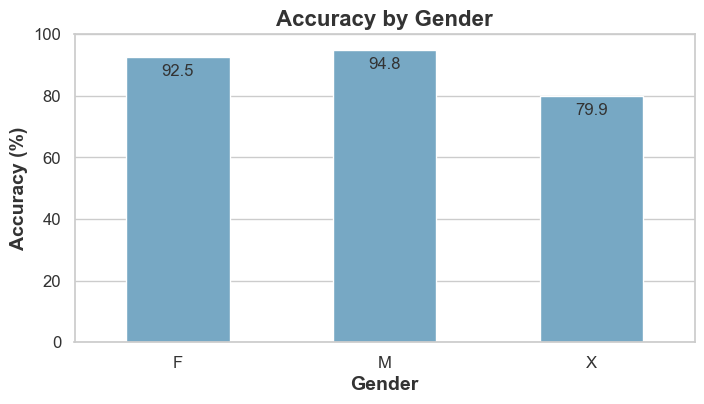

In [231]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# RANDOM SEED 3

In [232]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [233]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [234]:
tf.keras.backend.clear_session()

## Run Setup

In [235]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # # check group splits
    # check_initial_group_split(groups_train_val, groups_test)

    # # Specify the cat_ids that must be in the training/validation set
    # specific_cat_ids = ['000A', '046A']
    
    # # Perform the swapping operation
    # train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # # Re-assign the sets based on the updated indices
    # X_train_val, X_test = X[train_val_idx], X[test_idx]
    # y_train_val, y_test = y[train_val_idx], y[test_idx]
    # new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # # Find differences for training and test sets
    # moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    # moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # # Display the results
    # logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    # logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    # logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    # logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    # X_train_val = X[train_val_idx]
    # y_train_val = y[train_val_idx]
    # groups_train_val = groups[train_val_idx]
    
    # X_test = X[test_idx]
    # y_test = y[test_idx]
    # groups_test = groups[test_idx]

    # # logging identifier splits again after potential swaps
    # unique_train_val_groups = np.unique(groups_train_val)
    # unique_test_groups = np.unique(groups_test)
    
    # logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    # logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # # Verify the lengths are consistent
    # logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    # logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    # logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # # Check group splits once more
    # check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=300, batch_size=32,
                                  verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
051A    12
116A    12
016A    10
040A    10
051B     9
045A     9
094A     8
050A     7
109A     6
108A     6
044A     5
104A     4
056A     3
058A     3
113A     3
011A     2
054A     2
093A     2
041A     1
049A     1
043A     1
048A     1
115A     1
090A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
057A    27
014B    10
117A     7
061A     2
110A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    186
F     60
M     55
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    38
F     7
M     3
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 111A, 040A, 046A, 047A, 042A, 109A, 050...
senior    [093A, 097A, 106A, 104A, 055A, 059A, 113A, 116...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Se

Final Test Results - Loss: 0.3068283498287201, Accuracy: 0.8541666865348816, Precision: 0.7920168067226891, Recall: 0.8415233415233416, F1 Score: 0.8107042253521127
Confusion Matrix:
 [[ 9  2]
 [ 5 32]]
outer_fold 2
Train Set Group Distribution:
046A    63
047A    28
057A    27
097A    16
106A    14
042A    14
111A    13
116A    12
014B    10
016A    10
051B     9
045A     9
117A     7
108A     6
109A     6
044A     5
056A     3
058A     3
113A     3
054A     2
093A     2
061A     2
049A     1
048A     1
115A     1
110A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
055A    20
059A    14
051A    12
040A    10
094A     8
050A     7
104A     4
011A     2
043A     1
041A     1
090A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    205
M     36
F     28
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    39
M    22
X    19
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Se

Confusion Matrix:
 [[18  1]
 [ 3 58]]
outer_fold 3
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
042A    14
059A    14
051A    12
014B    10
040A    10
045A     9
094A     8
050A     7
117A     7
108A     6
104A     4
056A     3
011A     2
061A     2
041A     1
043A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
106A    14
111A    13
116A    12
016A    10
051B     9
109A     6
044A     5
113A     3
058A     3
093A     2
054A     2
049A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    192
F     52
M     25
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
M    33
X    32
F    15
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [014B, 040A, 046A, 047A, 042A, 050A, 043A, 041...
senior    [097A, 057A, 104A, 055A, 059A, 117A, 056A, 051...
Name: cat_id, dtype: object
Uniq

Majority Vote Accuracy for cat_id for this fold: 0.83 (10/12)
Before appending - Cat IDs: 128, Predictions: 128, Actuals: 128, Gender: 128
After appending - Cat IDs: 208, Predictions: 208, Actuals: 208, Gender: 208
Final Test Results - Loss: 0.3139762878417969, Accuracy: 0.862500011920929, Precision: 0.8472222222222222, Recall: 0.9, F1 Score: 0.8542805100182149
Confusion Matrix:
 [[25  0]
 [11 44]]
outer_fold 4
Train Set Group Distribution:
057A    27
055A    20
106A    14
059A    14
111A    13
051A    12
116A    12
016A    10
040A    10
014B    10
051B     9
094A     8
117A     7
050A     7
109A     6
044A     5
104A     4
058A     3
113A     3
061A     2
011A     2
054A     2
093A     2
049A     1
041A     1
043A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
046A    63
047A    28
097A    16
042A    14
045A     9
108A     6
056A     3
048A     1
115A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    

## Majority Voting on Total Entries per cat_id 

In [236]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 349, Predictions: 349, Actuals: 349, Gender: 349


In [237]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [238]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.84 (32/38)


In [239]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [240]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
28,104A,"[1, 1, 1, 1]",1,1.0,True
20,057A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",1,1.0,True
21,058A,"[1, 1, 1]",1,1.0,True
22,059A,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
24,090A,[1],1,1.0,True
26,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,097A,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]",1,1.0,True
30,108A,"[1, 1, 1, 1, 1, 1]",1,1.0,True
18,055A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True


In [241]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    13
1.0    19
Name: Majority_Correct, dtype: int64


In [242]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count   accuracy
0               0.0           16             13  81.250000
1               1.0           22             19  86.363636


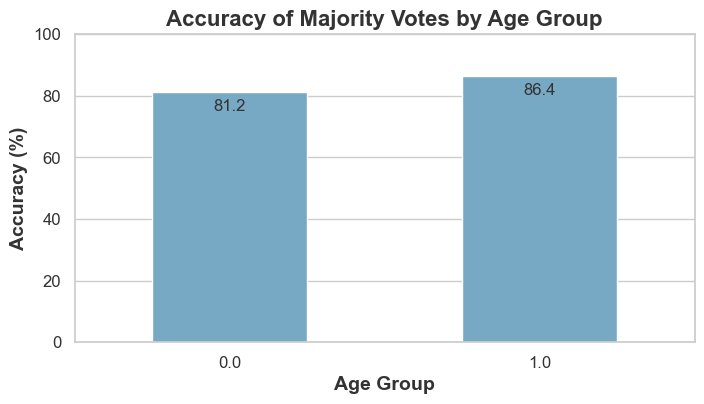

In [243]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [244]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          171             85  49.707602
1               1.0          178            156  87.640449


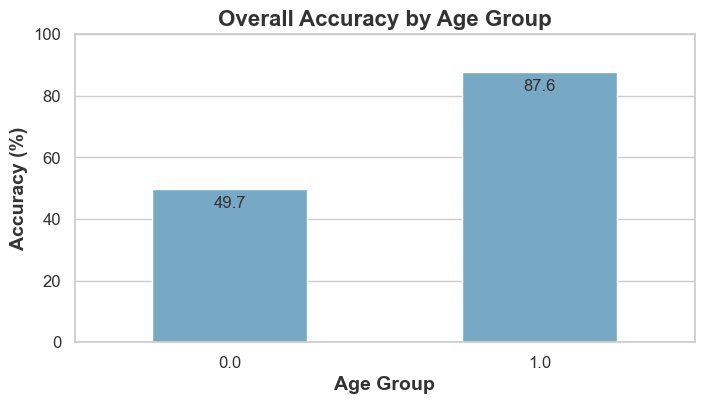

In [245]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')


## Gender Exploration

In [246]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       65     97.01
1          M     58       46     79.31
2          X    224      130     58.04


In [247]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       65     97.01
1          M     58       46     79.31
2          X    224      130     58.04


# RANDOM SEED 4

In [248]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [249]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [250]:
tf.keras.backend.clear_session()

## Run Setup

In [251]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # # check group splits
    # check_initial_group_split(groups_train_val, groups_test)

    # # Specify the cat_ids that must be in the training/validation set
    # specific_cat_ids = ['000A', '046A']
    
    # # Perform the swapping operation
    # train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # # Re-assign the sets based on the updated indices
    # X_train_val, X_test = X[train_val_idx], X[test_idx]
    # y_train_val, y_test = y[train_val_idx], y[test_idx]
    # new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # # Find differences for training and test sets
    # moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    # moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # # Display the results
    # logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    # logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    # logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    # logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    # X_train_val = X[train_val_idx]
    # y_train_val = y[train_val_idx]
    # groups_train_val = groups[train_val_idx]
    
    # X_test = X[test_idx]
    # y_test = y[test_idx]
    # groups_test = groups[test_idx]

    # # logging identifier splits again after potential swaps
    # unique_train_val_groups = np.unique(groups_train_val)
    # unique_test_groups = np.unique(groups_test)
    
    # logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    # logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # # Verify the lengths are consistent
    # logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    # logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    # logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # # Check group splits once more
    # check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=300, batch_size=32,
                                  verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
051A    12
116A    12
051B     9
045A     9
094A     8
117A     7
050A     7
109A     6
108A     6
044A     5
104A     4
056A     3
113A     3
011A     2
061A     2
054A     2
093A     2
041A     1
048A     1
043A     1
115A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
014B    10
040A    10
016A    10
058A     3
049A     1
110A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    199
F     67
M     48
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    25
M    10
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 111A, 046A, 047A, 042A, 109A, 050A, 043...
senior    [093A, 097A, 057A, 106A, 104A, 055A, 059A, 113...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_g

Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'kitten': 11, 'senior': 16}
Count of Unique Cat IDs per Age Group in Testing Set:
{'kitten': 5, 'senior': 6}
Unique Training/Validation Group IDs:
['011A' '014B' '016A' '040A' '041A' '042A' '043A' '045A' '048A' '049A'
 '051A' '054A' '056A' '057A' '058A' '059A' '061A' '093A' '097A' '104A'
 '106A' '108A' '109A' '110A' '113A' '115A' '116A']
Unique Test Group IDs:
['024A' '044A' '046A' '047A' '050A' '051B' '055A' '090A' '094A' '111A'
 '117A']
Train Age Group Distribution BEFORE SWAP:
senior    132
kitten     55
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
kitten    116
senior     46
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
senior    132
kitten     55
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
kitten    116
senior     46
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({1: 132,

Majority Vote Accuracy for cat_id for this fold: 0.91 (10/11)
Before appending - Cat IDs: 35, Predictions: 35, Actuals: 35, Gender: 35
After appending - Cat IDs: 197, Predictions: 197, Actuals: 197, Gender: 197
Final Test Results - Loss: 0.4762410819530487, Accuracy: 0.7592592835426331, Precision: 0.7705882352941176, Recall: 0.8318965517241379, F1 Score: 0.7501087687378871
Confusion Matrix:
 [[77 39]
 [ 0 46]]
outer_fold 3
Train Set Group Distribution:
046A    63
047A    28
055A    20
042A    14
111A    13
051A    12
016A    10
040A    10
014B    10
051B     9
094A     8
050A     7
117A     7
108A     6
109A     6
044A     5
058A     3
054A     2
093A     2
061A     2
049A     1
041A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
057A    27
097A    16
106A    14
059A    14
116A    12
045A     9
104A     4
113A     3
056A     3
011A     2
043A     1
048A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE


Confusion Matrix:
 [[11  0]
 [ 3 92]]
outer_fold 4
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
106A    14
059A    14
111A    13
116A    12
040A    10
016A    10
014B    10
051B     9
045A     9
094A     8
117A     7
050A     7
044A     5
104A     4
058A     3
056A     3
113A     3
011A     2
043A     1
049A     1
048A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
042A    14
051A    12
109A     6
108A     6
093A     2
054A     2
061A     2
041A     1
115A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    198
M     56
F     49
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    26
F    18
M     2
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 040A, 046A, 047A, 050A, 043...
senior    [097A, 057A, 106A, 104A, 055A, 059A, 113A, 116...
Name: cat_id, dtype: object
Uni

## Majority Voting on Total Entries per cat_id 

In [252]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 349, Predictions: 349, Actuals: 349, Gender: 349


In [253]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [254]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.95 (36/38)


In [255]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [256]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
1,014B,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0.0,True
21,058A,"[1, 1, 1]",1,1.0,True
22,059A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
23,061A,"[1, 1]",1,1.0,True
24,090A,[1],1,1.0,True
26,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,097A,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
28,104A,"[1, 1, 1, 1]",1,1.0,True
29,106A,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]",1,1.0,True


In [257]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    15
1.0    21
Name: Majority_Correct, dtype: int64


In [258]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count   accuracy
0               0.0           16             15  93.750000
1               1.0           22             21  95.454545


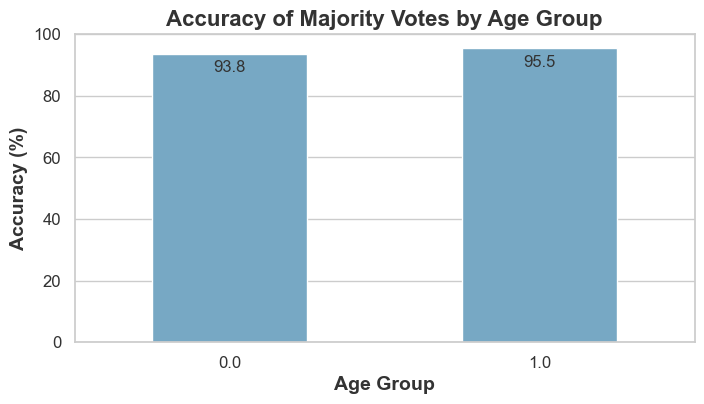

In [259]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [260]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          171            131  76.608187
1               1.0          178            170  95.505618


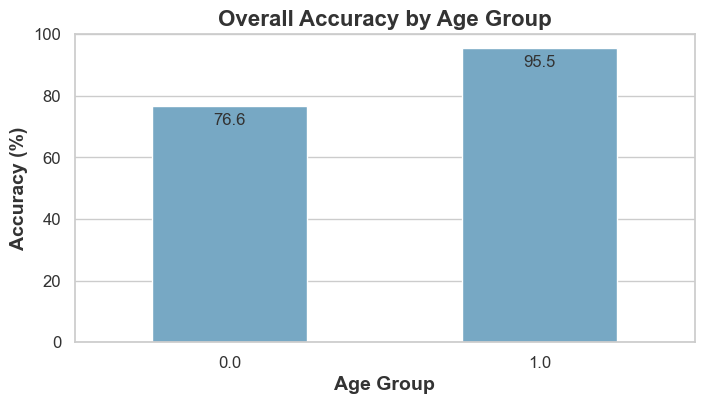

In [261]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')


## Gender Exploration

In [262]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       65     97.01
1          M     58       54     93.10
2          X    224      182     81.25


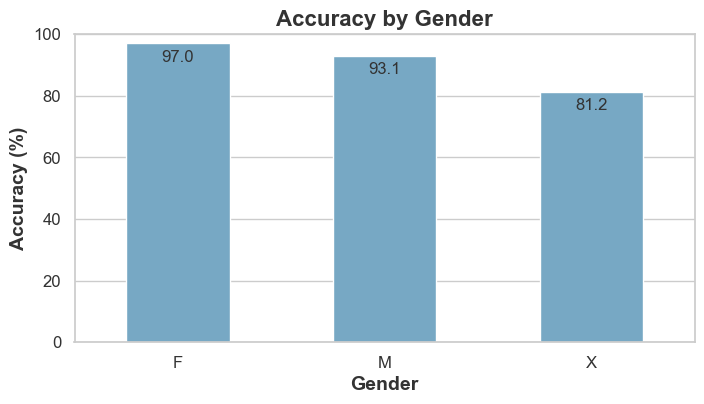

In [263]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# RANDOM SEED 5

In [264]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

# Drop Adult
dataframe.drop(dataframe[dataframe['age_group'] == 'adult'].index, inplace=True)

print(dataframe['age_group'].value_counts())

senior    178
kitten    171
Name: age_group, dtype: int64


In [265]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [266]:
tf.keras.backend.clear_session()

## Run Setup

In [267]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # # check group splits
    # check_initial_group_split(groups_train_val, groups_test)

    # # Specify the cat_ids that must be in the training/validation set
    # specific_cat_ids = ['000A', '046A']
    
    # # Perform the swapping operation
    # train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # # Re-assign the sets based on the updated indices
    # X_train_val, X_test = X[train_val_idx], X[test_idx]
    # y_train_val, y_test = y[train_val_idx], y[test_idx]
    # new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # # Find differences for training and test sets
    # moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    # moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # # Display the results
    # logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    # logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    # logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    # logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    # X_train_val = X[train_val_idx]
    # y_train_val = y[train_val_idx]
    # groups_train_val = groups[train_val_idx]
    
    # X_test = X[test_idx]
    # y_test = y[test_idx]
    # groups_test = groups[test_idx]

    # # logging identifier splits again after potential swaps
    # unique_train_val_groups = np.unique(groups_train_val)
    # unique_test_groups = np.unique(groups_test)
    
    # logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    # logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # # Verify the lengths are consistent
    # logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    # logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    # logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # # Check group splits once more
    # check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = y_train_val.astype('float32')
    y_test_encoded = y_test.astype('float32')

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    # Define optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units and input shape from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))
    model_full.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = optimizers['Adamax']  # optimizer selection
    
    # Compile the model for binary classification
    model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=300, batch_size=32,
                                  verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    # y_test_pred_prob = model_full.predict(X_test_scaled)
    # y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    # y_test_true = np.argmax(y_test_encoded, axis=1)    

    # Predict probabilities for the test set
    y_test_pred_prob = model_full.predict(X_test_scaled)
    
    # Convert probabilities to class labels (0 or 1) using a threshold of 0.5
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
    
    # y_test_encoded should be a 1D array of 0s and 1s if prepared as suggested for binary classification
    y_test_true = y_test_encoded

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = y_test_pred
    actual_labels = y_test_true
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
047A    28
057A    27
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
051A    12
016A    10
040A    10
014B    10
045A     9
094A     8
117A     7
050A     7
109A     6
044A     5
104A     4
056A     3
054A     2
093A     2
011A     2
061A     2
043A     1
041A     1
048A     1
115A     1
110A     1
090A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
116A    12
051B     9
108A     6
113A     3
058A     3
049A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    220
M     49
F     46
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    21
M     9
X     4
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
kitten    [044A, 014B, 111A, 040A, 046A, 047A, 042A, 109...
senior    [093A, 097A, 057A, 106A, 104A, 055A, 059A, 054...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Se

Epoch 1/300
10/10 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.7746
Epoch 2/300
10/10 [==============================] - 0s 1ms/step - loss: 0.3246 - accuracy: 0.8730
Epoch 3/300
10/10 [==============================] - 0s 1ms/step - loss: 0.2409 - accuracy: 0.8952
Epoch 4/300
10/10 [==============================] - 0s 1ms/step - loss: 0.2274 - accuracy: 0.9270
Epoch 5/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1980 - accuracy: 0.9206
Epoch 6/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1915 - accuracy: 0.9365
Epoch 7/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1651 - accuracy: 0.9587
Epoch 8/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1377 - accuracy: 0.9651
Epoch 9/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.9619
Epoch 10/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.9619
Epoch 11/

Majority Vote Accuracy for cat_id for this fold: 0.83 (5/6)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 34, Predictions: 34, Actuals: 34, Gender: 34
Final Test Results - Loss: 0.3420588970184326, Accuracy: 0.8823529481887817, Precision: 0.6, Recall: 0.9393939393939394, F1 Score: 0.6344086021505376
Confusion Matrix:
 [[ 1  0]
 [ 4 29]]
outer_fold 2
Train Set Group Distribution:
046A    63
047A    28
055A    20
097A    16
106A    14
042A    14
059A    14
111A    13
116A    12
040A    10
045A     9
051B     9
109A     6
108A     6
044A     5
104A     4
113A     3
056A     3
058A     3
054A     2
093A     2
011A     2
043A     1
049A     1
041A     1
048A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
057A    27
051A    12
014B    10
016A    10
094A     8
117A     7
050A     7
061A     2
115A     1
110A     1
090A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    178
F     47


Epoch 1/300
7/7 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.6422
Epoch 2/300
7/7 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.7745
Epoch 3/300
7/7 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8431
Epoch 4/300
7/7 [==============================] - 0s 2ms/step - loss: 0.3072 - accuracy: 0.8676
Epoch 5/300
7/7 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.8627
Epoch 6/300
7/7 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8971
Epoch 7/300
7/7 [==============================] - 0s 2ms/step - loss: 0.2227 - accuracy: 0.9167
Epoch 8/300
7/7 [==============================] - 0s 1ms/step - loss: 0.2572 - accuracy: 0.9216
Epoch 9/300
7/7 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.9363
Epoch 10/300
7/7 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.9314
Epoch 11/300
7/7 [===========

Majority Vote Accuracy for cat_id for this fold: 0.92 (11/12)
Before appending - Cat IDs: 120, Predictions: 120, Actuals: 120, Gender: 120
After appending - Cat IDs: 265, Predictions: 265, Actuals: 265, Gender: 265
Final Test Results - Loss: 0.47924816608428955, Accuracy: 0.7379310131072998, Precision: 0.7818181818181817, Recall: 0.7798956661316212, F1 Score: 0.7379185692541856
Confusion Matrix:
 [[53 36]
 [ 2 54]]
outer_fold 4
Train Set Group Distribution:
046A    63
057A    27
055A    20
097A    16
042A    14
059A    14
116A    12
051A    12
014B    10
016A    10
051B     9
045A     9
094A     8
117A     7
050A     7
108A     6
056A     3
058A     3
113A     3
061A     2
011A     2
090A     1
110A     1
115A     1
043A     1
048A     1
041A     1
049A     1
024A     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
047A    28
106A    14
111A    13
040A    10
109A     6
044A     5
104A     4
093A     2
054A     2
Name: cat_id, dtype: int64
Training Set Gender Distribution B

## Majority Voting on Total Entries per cat_id 

In [268]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 349, Predictions: 349, Actuals: 349, Gender: 349


In [269]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [270]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.89 (34/38)


In [271]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [280]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,011A,"[1, 1]",1,1.0,True
29,106A,"[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]",1,1.0,True
20,057A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True
22,059A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
24,090A,[1],1,1.0,True
26,094A,"[1, 1, 1, 1, 1, 1, 1, 1]",1,1.0,True
27,097A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]",1,1.0,True
28,104A,"[1, 1, 1, 1]",1,1.0,True
30,108A,"[0, 1, 1, 1, 1, 0]",1,1.0,True
18,055A,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.0,True


In [281]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
0.0    15
1.0    19
Name: Majority_Correct, dtype: int64


In [282]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
   actual_age_group  total_count  correct_count   accuracy
0               0.0           16             15  93.750000
1               1.0           22             19  86.363636


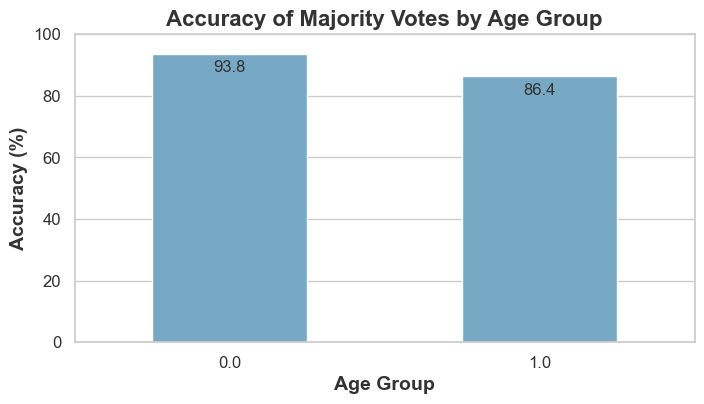

In [283]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [284]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
   actual_age_group  total_count  correct_count   accuracy
0               0.0          171            133  77.777778
1               1.0          178            154  86.516854


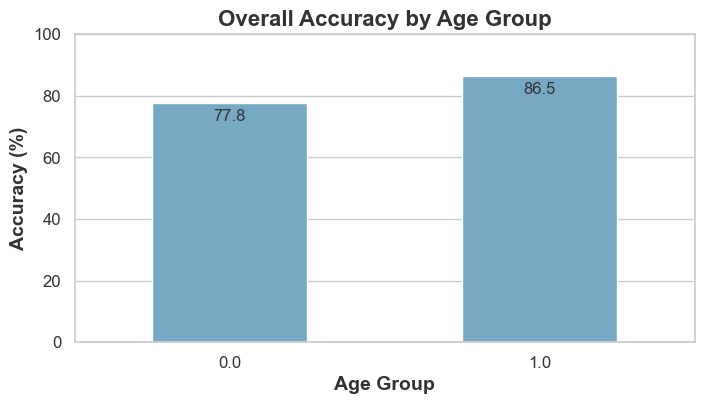

In [290]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [289]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F     67       61     91.04
1          M     58       50     86.21
2          X    224      176     78.57


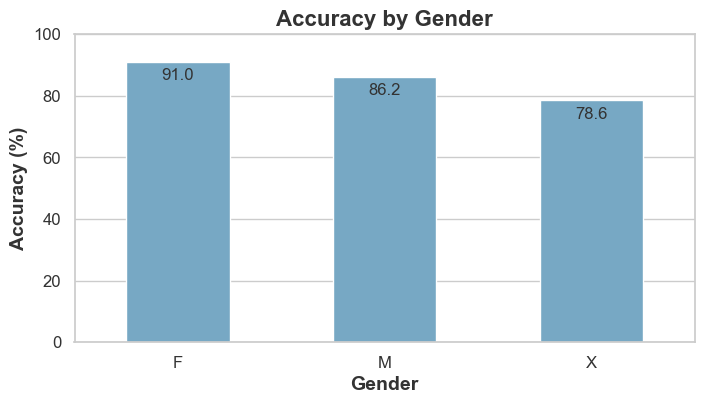

In [287]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')